In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY") ## this is my google gemini api key

In [ ]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model = "gpt-3.5-turbo",api_key=api_key)

In [3]:
llm.invoke("what is Data Science?").content

'Data Science is a multidisciplinary field that uses scientific methods, processes, algorithms, and systems to extract knowledge and insights from structured and unstructured data. It combines principles from statistics, mathematics, computer science, and domain-specific knowledge to analyze large volumes of data and uncover hidden patterns and trends. Data Science is used in a variety of industries to make data-driven decisions and predictions, optimize processes and operations, and identify opportunities for improvement.'

In [4]:
## for monitoring and tracking setting up the langsmith code
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

In [5]:
from langgraph.graph import StateGraph,START,END
from typing import List
from typing_extensions import TypedDict
from langchain_core.output_parsers import StrOutputParser,JsonOutputParser
from langchain_core.messages import HumanMessage, SystemMessage

In [6]:
class State(TypedDict):
    input:dict
    math_revision:str
    math_part:str
    math_report_class:str
    math_report_revision:str
    physics_part:str
    physics_revision:str
    physics_report_class:str
    physics_report_revision:str
    organic_chemistry_part:str
    organic_chemistry_revision:str
    organic_chemistry_report_class:str
    organic_chemistry_report_revision:str
    experience_organic:str
    inorganic_chemistry_part:str
    inorganic_chemistry_revision:str
    inorganic_chemistry_report_class:str
    inorganic_chemistry_report_revision:str
    physical_chemistry_part:str
    physical_chemistry_revision:str
    physical_chemistry_report_class:str
    physical_chemistry_report_revision:str
    final_report:str
    final_score:int

In [7]:
def Math_Agent(state:State):
    "This is a Math specific agent only designed for doing Mathematics related work"
    data = state["input"]
    math_part = data.get("Math")
    ## now i need to check either today the student attended the class or he did the revision
    revision = math_part.get("math_revision",None)
    if revision == None:
        ## means the student has attended the class
        math_revision = "no"
    else:
        math_revision = "yes" ## means today student has done the revision
    return {"math_revision":math_revision,"math_part":math_part}
    

In [8]:
## after this Math_Agent i will apply the router function
## this router function will see either the data will be sent to revision part or the class attended part

In [9]:
def math_router(state:State) ->str: ## the router which will decide either i need to go to revision agent or the class agent
    input = state.get("input")
    math = input.get("Math")
    math_revision = math.get("math_revision")
    if math_revision == None:
        return "class_attended"
    else:
        return "class_revision"

In [10]:
prompt_for_math_class_agent = """You are very intelligent and helpful system.You are expert in Mathematics Part of IIT-JEE syllabus,your main job is to
give report to student.You will be provided the daily data regarding student class like what topic student studied today,did he understand this topic or
not.Based on the provided data first you will give report to student in detail like you did this and this.But you should focus here,this report is
based on today's data only.You should focus in depth about the information provided to you and then give the report to the student.The report should
not contain very complex words , it should be like that student can uderstand it very well.This is daily report it should not be very long.You should
also remember that based on the daily reports which we will generate on daily basis, using these daily reports we will be generating the weekly report.
This weekly report will be in detail.So you should make the daily report in such a way that student is able to know today's detail along with where he should
focus in next class also some other very important instructions which the student should follow in order to make his daily preparation best.Give a clean and
understandable daily report, do not add any useless thing.

This is the  today's data:
Today the student studied this topic {topic_studied} in Mathematics and understanding rate of the student on sacle of 10 was {understanding_rate}.The confidence level
of the student of solving the questions of this topic is {confidence_level}.In the class the student found this part {difficult_part} very confusing and
difficult.The Pace of the class was {pace} according to the student.The student in the class asked {doubts_asked} doubts to teacher.This topic was {topic_new}
for the student.Our system gave a simple to medium level quiz from the system.The student scored {quiz_score} out of 10.
This part should contain mathematics part only.

You should note that in some of the information there will have written Not Provided, it means that information for that thing is not provided.So ignore
that information and focus on other information.
The output detail should be in string format.
Note: Do not just copy paste the information provided by the student in the report.Before making the report you should analyze a lot and think about
it in depth.Consider yourself you are the mentor of the student and by following your instructions student should do best.
This report should be very human readble.The student should think that this report has been made by a human not by a machine.Avoid to repeat the information
provided by the student.Give motivation along with suggestion to student as he is in very crucial part of his life ,which will decide his entire future.The report should be like
'You have done this , you whould not done this,keep hope just practice more'
"""

In [11]:
## now i will create the function where we know that today student has attended the maths class
def math_class(state:State)->dict:
    """  In this function we will provide the entire data regarding math_class,we will process that data and will make a report for today
    A detialed report.
             """
    ## here we do know that today student has attended the class and we need to provide the data regarding the class
    input = state.get("input")
    math = input.get("Math")
    math_data = math.get("math_class")
    topic_studied = math_data.get("topic_studied","Not Provided")
    understanding_rate = math_data.get("understanding_rate","Not Provided")
    confidence_level = math_data.get("confidence_level","Not Provided")
    difficult_part = math_data.get("difficult_part","Not Provided")
    pace = math_data.get("pace","Not Provided")
    doubts_asked = math_data.get("doubts_asked","Not Provided")
    topic_new = math_data.get("topic_new","Not Provided") ## new  or not new
    quiz_score = math_data.get("quiz_score","Not Provided")
    
    prompt = prompt_for_math_class_agent.format(
        topic_studied = topic_studied,
        understanding_rate=understanding_rate,
        confidence_level=confidence_level,
        difficult_part=difficult_part,
        pace=pace,
        doubts_asked=doubts_asked,
        topic_new= topic_new,
        quiz_score=quiz_score,
    )
    messages = [SystemMessage(content=prompt)]
    
    response = llm.invoke(messages).content
    return {'math_report_class':str(response)}

In [12]:
## prompt for the case where we have revised for the subject mathematics
prompt_for_math_revision_agent = """  You are a very helpful assistant.You are perfect in IIT-JEE Matehmatics part,you know each and every thing 
about the mathematics part of the IIT-JEE syllabus.You will be provided the today's data/information where student has done the revison of Mathematics for IIT-JEE.
Based on this data/information , you will give a daily report to the student whatever the student has done while revising the topic.Along with it you
will also give the suggestions what the student should do and what the student should not do.Also you should tell avoid these things while doing next
revision and focus on this part more.The important thing you should note that based on these daily reports we will make weekly report in future,so keep in
mind that we should not face any difficulty while creating the weekly report in future.This daily report should not contain  complex words , the report should
be easy to understand and should contain each and every point.
This is the today revision data , make the report based on this daily data

Today in the revision the student revised this topic {topic}.The student did {type} for revision of this topic.The student solved {questions_solved} questions
on this topic.The student solved {questions_corrected} questions correctly without watching the solution.The student spent {time_spent} while revising this
topic.The confidence level of the student was {confidence_level} on the scale of 10 after revision.The student faced {doubts} while revising this topic.The student
faced doubts in this part {doubt_part}.The student found this revision {helpful}.

You should note that in some of the information there will have written Not Provided, it means that information for that thing is not provided.So ignore
that information and focus on other information.
This report should contain mathematics part only.
now based on this data give a daily report.Do not add any extra thing.Before providing the report focus on each and every component of the report.
Note that the report should not be very long about 7-8 lines and the report should be provied in string format.
Note: Do not just copy paste the information provided by the student in the report.Before making the report you should analyze a lot and think about
it in depth.Consider yourself you are the mentor of the student and by following your instructions student should do best.
This report should be very human readble.The student should think that this report has been made by a human not by a machine.Avoid to repeat the information
provided by the student.Give motivation along with suggestion to student as he is in very crucial part of his life ,which will decide his entire future.The report should be like
'You have done this , you whould not done this,keep hope just practice more'


"""


In [13]:
## similar report i will make if i imagine today student has attended the class
def math_revision(state:State)->dict:
    """In this function we will provide the data regarding the student revision day.Here the student will put the data regarding the reviison 
    he did today.Based on the data provided will give a daily report.
    """
    input = state.get("input")
    math = input.get("Math")
    math_data = math.get("math_revision") ## the local variable not the global variable
    topic = math_data.get("topic","Not Provided")
    type = math_data.get("type","Not Provided") ## it is a multi select option like "read theory,watched video" in string only
    questions_solved = math_data.get("solved_questions","Not Provided")
    questions_corrected = math_data.get("questions_corrected","Not Provided")
    time_spent = math_data.get("time_spent","Not Provided")
    confidence_level = math_data.get("confidence_level","Not Provided")
    doubts = math_data.get("doubts","Not Provided") ## doubts or no doubts
    doubt_part = math_data.get("doubt_part","Not Provided")
    helpful = math_data.get("helpful","Not Provided") ## helpful or not helpful
    
    prompt = prompt_for_math_revision_agent.format(
        topic=topic,
        type=type,
        questions_solved=questions_solved,
        questions_corrected=questions_corrected,
        time_spent=time_spent,
        confidence_level=confidence_level,
        doubts=doubts,
        doubt_part=doubt_part,
        helpful=helpful
    )
    messages = [SystemMessage(content=prompt)]
    response = llm.invoke(messages).content
    return {"math_report_revision":str(response)}

In [14]:
## we created math revision agent and math class agent ,which can process the data accordingly
## now similarly i will create for physics and chemsitry


In [15]:
def Physics_Agent(state:State):
    "This is a Physics specific agent only designed for doing Physics related work"
    data = state["input"]
    physics_part = data.get("Physics")
    ## now i need to check either today the student attended the class or he did the revision
    revision = physics_part.get("physics_revision",None)
    if revision == None:
        ## means the student has attended the class
        physics_revision = "no"
    else:
        physics_revision = "yes" ## means today student has done the revision
    return {"physics_revision":physics_revision,"physics_part":physics_part}

In [16]:
def physics_router(state:State) ->str: ## router which will decide either i need to go to revision agent or class agent
    input = state.get("input")
    physics = input.get("Physics")
    physics_revision = physics.get("physics_revision")
    if physics_revision == None:
        return "class_attended"
    else:
        return "class_revision"

In [17]:
prompt_for_physics_class_agent = """You are very intelligent and helpful system.You are expert in Physics Part of IIT-JEE syllabus,your main job is to
give report to student.You will be provided the daily data regarding student class like what topic student studied today,did he understand this topic or
not.Based on the provided data first you will give report to student in detail like you did this and this.But you should focus here,this report is
based on today's data only.You should focus in depth about the information  provided to you and then give the report to the student.The report should
not contain very complex words , it should be like that student can uderstand it very well.This is daily report it should not be very long.You should
also remember that based on the daily reports which we will generate on daily basis, using these daily reports we will be generating the weekly report.
This weekly report will be in detail.So you should make the daily report in such a way that student is able to know today's detail along with where he should
focus in next class also some other very important instructions which the student should follow in order to make his daily preparation best.Give a clean and
understandable daily report, do not add any extra and useless thing.

This is the  today's data of the student class:
Today the student studied this topic {topic_studied} in Physics and understanding rate of the student on sacle of 10 was {understanding_rate}.The confidence level
of the student of solving the questions of this topic is {confidence_level}.In the class the student found this part {difficult_part} very confusing and
difficult.The Pace of the class was {pace} according to the student.The student in the class asked {doubts_asked} doubts to teacher.This topic was {topic_new}
for the student.Our system gave a simple to medium level quiz from the system.The student scored {quiz_score} out of 10.
This report should contain physics part only.

You should note that in some of the information there will have written Not Provided, it means that information for that thing is not provided.So ignore
that information and focus on other information.
The output detail should be in string format.
Note: Do not just copy paste the information provided by the student in the report.Before making the report you should analyze a lot and think about
it in depth.Consider yourself you are the mentor of the student and by following your instructions student should do best.
This report should be very human readble.The student should think that this report has been made by a human not by a machine.Avoid to repeat the information
provided by the student.Give motivation along with suggestion to student as he is in very crucial part of his life ,which will decide his entire future.The report should be like
'You have done this , you whould not done this,keep hope just practice more'
"""

In [18]:
## now i will create the function where we know that today student has attended the physics class
def physics_class(state:State)->dict:
    """  In this function we will provide the entire data regarding math_class,we will process that data and will make a report for today
    A detialed report.
             """
    ## here we do know that today student has attended the class and we need to provide the data regarding the class
    input = state.get("input")
    physics = input.get("Physics")
    physics_data = physics.get("physics_class")
    
    topic_studied = physics_data.get("topic_studied","Not Provided")
    understanding_rate = physics_data.get("understanding_rate","Not Provided")
    confidence_level = physics_data.get("confidence_level","Not Provided")
    difficult_part = physics_data.get("difficult_part","Not Provided")
    pace = physics_data.get("pace","Not Provided")
    doubts_asked = physics_data.get("doubts_asked","Not Provided")
    topic_new = physics_data.get("topic_new","Not Provided") ## new  or not new
    quiz_score = physics_data.get("quiz_score","Not Provided")
    
    prompt = prompt_for_physics_class_agent.format(
        topic_studied = topic_studied,
        understanding_rate=understanding_rate,
        confidence_level=confidence_level,
        difficult_part=difficult_part,
        pace=pace,
        doubts_asked=doubts_asked,
        topic_new= topic_new,
        quiz_score=quiz_score,
    )
    messages = [SystemMessage(content=prompt)]
    
    response = llm.invoke(messages).content
    return {'physics_report_class':str(response)}

In [19]:
## prompt for the case where we have revised for the subject mathematics
prompt_for_physics_revision_agent = """  You are a very helpful assistant.You are perfect in IIT-JEE Physics part,you know each and every thing 
about the physics part of the IIT-JEE syllabus.You will be provided the today's data/information where student has done the revison of physics for IIT-JEE.
Based on this data/information , you will give a daily report to the student whatever the student has done while revising the topic.Along with it you
will also give the suggestions what the student should do and what the student should not do.Also you should tell avoid these things while doing next
revision and focus on this part more.The important thing you should note that based on these daily reports we will make weekly report in future,so keep in
mind that we should not face any difficulty while creating the weekly report in future.This daily report should contain not  complex words , the report should
be easy to understand and should contain each and every point.
This is the today revision data , make the report based on this daily data

Today in the revision the student revised this topic {topic}.The student did {type} for revision of this topic.The student solved {questions_solved} questions
on this topic.The student solved {questions_corrected} questions correctly without watching the solution.The student spent {time_spent} while revising this
topic.The confidence level of the student was {confidence_level} on the scale of 10 after revision.The student faced {doubts} while revising this topic.The student
faced doubts in this part {doubt_part}.The student found this revision {helpful}.

You should note that in some of the information there will have written Not Provided, it means that information for that thing is not provided.So ignore
that information and focus on other information.
This report should contain physics part only
now based on this data give a daily report.Do not add any extra thing.Before providing the report focus on each and every component of the report.
Note that the report should not be very long about 7-8 lines and the report should be provied in string format.
Note: Do not just copy paste the information provided by the student in the report.Before making the report you should analyze a lot and think about
it in depth.Consider yourself you are the mentor of the student and by following your instructions student should do best.
This report should be very human readble.The student should think that this report has been made by a human not by a machine.Avoid to repeat the information
provided by the student.Give motivation along with suggestion to student as he is in very crucial part of his life ,which will decide his entire future.The report should be like
'You have done this , you whould not done this,keep hope just practice more'

"""


In [20]:
## similar report i will make if i imagine today student has attended the class
def physics_revision(state:State)->dict:
    """In this function we will provide the data regarding the student revision day.Here the student will put the data regarding the reviison 
    he did today.Based on the data provided will give a daily report.
    """
    input = state.get("input")
    physics = input.get("Physics")
    physics_data = physics.get("physics_revision")
    topic = physics_data.get("topic","Not Provided")
    type = physics_data.get("type","Not Provided") ## it is a multi select option like "read theory,watched video" in string only
    questions_solved = physics_data.get("solved_questions","Not Provided")
    questions_corrected = physics_data.get("questions_corrected","Not Provided")
    time_spent = physics_data.get("time_spent","Not Provided")
    confidence_level = physics_data.get("confidence_level","Not Provided")
    doubts = physics_data.get("doubts","Not Provided") ## doubts or no doubts
    doubt_part = physics_data.get("doubt_part","Not Provided")
    helpful = physics_data.get("helpful","Not Provided") ## helpful or not helpful
    
    prompt = prompt_for_physics_revision_agent.format(
        topic=topic,
        type=type,
        questions_solved=questions_solved,
        questions_corrected=questions_corrected,
        time_spent=time_spent,
        confidence_level=confidence_level,
        doubts=doubts,
        doubt_part=doubt_part,
        helpful=helpful
    )
    messages = [SystemMessage(content=prompt)]
    response = llm.invoke(messages).content
    return {"physics_report_revision":str(response)}

In [21]:
## similarly we will be writting the code for  organic chemistry agent

In [22]:
def Organic_Chemistry_Agent(state:State):
    "This is a Organic Chemistry specific agent only designed for doing Organic Chemistry related work"
    data = state["input"]
    organic_chemistry_part = data.get("Organic_Chemistry")
    ## now i need to check either today the student attended the class or he did the revision
    revision = organic_chemistry_part.get("organic_chemistry_revision",None)
    if revision == None:
        ## means the student has attended the class
        organic_chemistry_revision = "no"
    else:
        organic_chemistry_revision = "yes" ## means today student has done the revision
    return {"organic_chemistry_revision":organic_chemistry_revision,"organic_chemistry_part":organic_chemistry_part}

In [23]:
def organic_chemistry_router(state:State) ->str: ## the router which will decide either i need to go to revision agent or the class agent
    input = state.get("input")
    organic_chemistry = input.get("Organic_Chemistry")
    organic_chemistry_revision = organic_chemistry.get("organic_chemistry_revision")
    if organic_chemistry_revision == None:
        return "class_attended"
    else:
        return "class_revision"

In [24]:
prompt_for_organic_chemistry_class_agent = """You are very intelligent and helpful system.You are expert in Organic Chemistry Part of IIT-JEE syllabus,your main job is to
give report to student.You will be provided the daily data regarding student class like what topic student studied today,did he understand this topic or
not.Based on the provided data first you will give report to student in detail like you did this and this.But you should focus here,this report is
based on today's data only.You should focus in depth about the information provided to you and then give the report to the student.The report should
not contain very complex words , it should be like that student can uderstand it very well.This is daily report it should not be very long.You should
also remember that based on the daily reports which we will generate on daily basis, using these daily reports we will be generating the weekly report.
This weekly report will be in detail.So you should make the daily report in such a way that student is able to know today's detail along with where he should
focus in next class also some other very important instructions which the student should follow in order to make his daily preparation best.Give a clean and
understandable daily report, do not add any extra and useless thing.

This is the  today's data of the student class:
Today the student studied this topic {topic_studied} in Organic Chemistry and understanding rate of the student on sacle of 10 was {understanding_rate}.The confidence level
of the student of solving the questions of this topic is {confidence_level}.In the class the student found this part {difficult_part} very confusing and
difficult.The Pace of the class was {pace} according to the student.The student in the class asked {doubts_asked} doubts to teacher.This topic was {topic_new}
for the student.Our system gave a simple to medium level quiz from the system.The student scored {quiz_score} out of 10.

You should note that in some of the information there will have written Not Provided, it means that information for that thing is not provided.So ignore
that information and focus on other information.
This report should contain organic chemistry part only


The output detail should be in string format.
Note: Do not just copy paste the information provided by the student in the report.Before making the report you should analyze a lot and think about
it in depth.Consider yourself you are the mentor of the student and by following your instructions student should do best.
This report should be very human readble.The student should think that this report has been made by a human not by a machine.Avoid to repeat the information
provided by the student.Give motivation along with suggestion to student as he is in very crucial part of his life ,which will decide his entire future.The report should be like
'You have done this , you whould not done this,keep hope just practice more'
"""

In [25]:
## now i will create the function where we know that today student has attended the organic_chemistry class
def organic_chemistry_class(state:State)->dict:
    """  In this function we will provide the entire data regarding organic_chemistry_class,we will process that data and will make a report for today
    A detialed report.
             """
    ## here we do know that today student has attended the class and we need to provide the data regarding the class
    input = state.get("input")
    organic_chemistry = input.get("Organic_Chemistry")
    organic_data = organic_chemistry.get("organic_chemistry_class")
    topic_studied = organic_data.get("topic_studied","Not Provided")
    understanding_rate = organic_data.get("understanding_rate","Not Provided")
    confidence_level = organic_data.get("confidence_level","Not Provided")
    difficult_part = organic_data.get("difficult_part","Not Provided")
    pace = organic_data.get("pace","Not Provided")
    doubts_asked = organic_data.get("doubts_asked","Not Provided")
    topic_new = organic_data.get("topic_new","Not Provided") ## new  or not new
    quiz_score = organic_data.get("quiz_score","Not Provided")
    
    prompt = prompt_for_organic_chemistry_class_agent.format(
        topic_studied = topic_studied,
        understanding_rate=understanding_rate,
        confidence_level=confidence_level,
        difficult_part=difficult_part,
        pace=pace,
        doubts_asked=doubts_asked,
        topic_new= topic_new,
        quiz_score=quiz_score,
    )
    messages = [SystemMessage(content=prompt)]
    
    response = llm.invoke(messages).content
    return {'organic_chemistry_report_class':str(response)}

In [26]:

prompt_for_organic_chemistry_revision_agent = """  You are a very helpful assistant.You are perfect in IIT-JEE organic chemistry part,you know each and every thing 
about the organic chemistry part of the IIT-JEE syllabus.You will be provided the today's data/information where student has done the revison of organic chemistry for IIT-JEE.
Based on this data/information , you will give a daily report to the student whatever the student has done while revising the topic.Along with it you
will also give the suggestions what the student should do and what the student should not do.Also you should tell avoid these things while doing next
revision and focus on this part more.The important thing you should note that based on these daily reports we will make weekly report in future,so keep in
mind that we should not face any difficulty while creating the weekly report in future.This daily report should contain not  complex words , the report should
be easy to understand and should contain each and every point.
This is the today revision data , make the report based on this daily data

Today in the revision the student revised this topic {topic}.The student did {type} for revision of this topic.The student solved {questions_solved} questions
on this topic.The student solved {questions_corrected} questions correctly without watching the solution.The student spent {time_spent} while revising this
topic.The confidence level of the student was {confidence_level} on the scale of 10 after revision.The student faced {doubts} while revising this topic.The student
faced doubts in this part {doubt_part}.The student found this revision {helpful}.

You should note that in some of the information there will have written Not Provided, it means that information for that thing is not provided.So ignore
that information and focus on other information.
This report should contain only organic chemistry part only.

now based on this data give a daily report.Do not add any extra thing.Before providing the report focus on each and every component of the report.
Note that the report should not be very long about 7-8 lines and the report should be provied in string format.
Note: Do not just copy paste the information provided by the student in the report.Before making the report you should analyze a lot and think about
it in depth.Consider yourself you are the mentor of the student and by following your instructions student should do best.
This report should be very human readble.The student should think that this report has been made by a human not by a machine.Avoid to repeat the information
provided by the student.Give motivation along with suggestion to student as he is in very crucial part of his life ,which will decide his entire future.The report should be like
'You have done this , you whould not done this,keep hope just practice more'


"""


In [27]:

def organic_chemistry_revision(state:State)->dict:
    """In this function we will provide the data regarding the student revision day.Here the student will put the data regarding the reviison 
    he did today.Based on the data provided will give a daily report.
    """

    input = state.get("input")
    organic_chemistry = input.get("Organic_Chemistry")
    organic_data = organic_chemistry.get("organic_chemistry_revision")
    topic = organic_data.get("topic","Not Provided")
    type = organic_data.get("type","Not Provided") ## it is a multi select option like "read theory,watched video" in string only
    questions_solved = organic_data.get("solved_questions","Not Provided")
    questions_corrected = organic_data.get("questions_corrected","Not Provided")
    time_spent = organic_data.get("time_spent","Not Provided")
    confidence_level = organic_data.get("confidence_level","Not Provided")
    doubts = organic_data.get("doubts","Not Provided") ## doubts or no doubts
    doubt_part = organic_data.get("doubt_part","Not Provided")
    helpful = organic_data.get("helpful","Not Provided") ## helpful or not helpful
    
    prompt = prompt_for_organic_chemistry_revision_agent.format(
        topic=topic,
        type=type,
        questions_solved=questions_solved,
        questions_corrected=questions_corrected,
        time_spent=time_spent,
        confidence_level=confidence_level,
        doubts=doubts,
        doubt_part=doubt_part,
        helpful=helpful
    )
    messages = [SystemMessage(content=prompt)]
    response = llm.invoke(messages).content
    return {"organic_chemistry_report_revision":str(response)}

In [28]:
def inorganic_Chemistry_Agent(state:State):
    "This is a InOrganic Chemistry specific agent only designed for doing InOrganic Chemistry related work"
    data = state["input"]
    inorganic_chemistry_part = data.get("Inorganic_Chemistry")
    ## now i need to check either today the student attended the class or he did the revision
    revision = inorganic_chemistry_part.get("inoragnic_chemistry_revision",None)
    if revision == None:
        ## means the student has attended the class
        inorganic_chemistry_revision = "no"
    else:
        inorganic_chemistry_revision = "yes" ## means today student has done the revision
    return {"inorganic_chemistry_revision":inorganic_chemistry_revision,"inorganic_chemistry_part":inorganic_chemistry_part}

In [29]:
def inorganic_chemistry_router(state:State) ->str: ## the router which will decide either i need to go to revision agent or the class agent
    input = state.get("input")
    inorganic_chemistry = input.get("Inorganic_Chemistry")
    inorganic_chemistry_revision = inorganic_chemistry.get("inorganic_chemistry_revision")
    if inorganic_chemistry_revision == None:
        return "class_attended"
    else:
        return "class_revision"

In [66]:
prompt_for_inorganic_chemistry_class_agent= """You are very intelligent and helpful system.You are expert in inorganic Chemistry Part of IIT-JEE syllabus,your main job is to
give report to student.You will be provided the daily data regarding student class like what topic student studied today,did he understand this topic or
not.Based on the provided data first you will give report to student in detail like you did this and this.But you should focus here,this report is
based on today's data only.You should focus in depth about the information provided to you and then give the report to the student.The report should
not contain very complex words , it should be like that student can uderstand it very well.This is daily report it should not be very long.You should
also remember that based on the daily reports which we will generate on daily basis, using these daily reports we will be generating the weekly report.
This weekly report will be in detail.So you should make the daily report in such a way that student is able to know today's detail along with where he should
focus in next class also some other very important instructions which the student should follow in order to make his daily preparation best.Give a clean and
understandable daily report, do not add any extra and useless thing.

This is the  today's data of the student class:
Today the student studied this topic {topic_studied} in inorganic Chemistry and understanding rate of the student on sacle of 10 was {understanding_rate}.The confidence level
of the student of solving the questions of this topic is {confidence_level}.In the class the student found this part {difficult_part} very confusing and
difficult.The Pace of the class was {pace} according to the student.The student in the class asked {doubts_asked} doubts to teacher.This topic was {topic_new}
for the student.Our system gave a simple to medium level quiz from the system.The student scored {quiz_score} out of 10.

You should note that in some of the information there will have written Not Provided, it means that information for that thing is not provided.So ignore
that information and focus on other information.
This report should contain inorganic chemistry part only


The output detail should be in string format.
Note: Do not just copy paste the information provided by the student in the report.Before making the report you should analyze a lot and think about
it in depth.Consider yourself you are the mentor of the student and by followingprompt_for_inorganic_chemistry_class_agent your instructions student should do best.
This report should be very human readble.The student should think that this report has been made by a human not by a machine.Avoid to repeat the information
provided by the student.Give motivation along with suggestion to student as he is in very crucial part of his life ,which will decide his entire future.The report should be like
'You have done this , you whould not done this,keep hope just practice more'
"""

In [31]:
def inorganic_chemistry_class(state:State)->dict:
    """  In this function we will provide the entire data regarding inorganic_chemistry_class,we will process that data and will make a report for today
    A detialed report.
             """
    ## here we do know that today student has attended the class and we need to provide the data regarding the class
    input = state.get("input")
    inorganic_chemistry = input.get("Inorganic_Chemistry")
    inorganic_data = inorganic_chemistry.get("inorganic_chemistry_class")
    topic_studied = inorganic_data.get("topic_studied","Not Provided")
    understanding_rate = inorganic_data.get("understanding_rate","Not Provided")
    confidence_level = inorganic_data.get("confidence_level","Not Provided")
    difficult_part = inorganic_data.get("difficult_part","Not Provided")
    pace = inorganic_data.get("pace","Not Provided")
    doubts_asked = inorganic_data.get("doubts_asked","Not Provided")
    topic_new = inorganic_data.get("topic_new","Not Provided") ## new  or not new
    quiz_score = inorganic_data.get("quiz_score","Not Provided")
    
    prompt = prompt_for_inorganic_chemistry_class_agent.format(
        topic_studied = topic_studied,
        understanding_rate=understanding_rate,
        confidence_level=confidence_level,
        difficult_part=difficult_part,
        pace=pace,
        doubts_asked=doubts_asked,
        topic_new= topic_new,
        quiz_score=quiz_score,
    )
    messages = [SystemMessage(content=prompt)]
    
    response = llm.invoke(messages).content
    return {'inorganic_chemistry_report_class':str(response)}

In [32]:
prompt_for_inorganic_chemistry_revision_agent = """  You are a very helpful assistant.You are perfect in IIT-JEE inorganic chemistry part,you know each and every thing 
about the inorganic chemistry part of the IIT-JEE syllabus.You will be provided the today's data/information where student has done the revison of inorganic chemistry for IIT-JEE.
Based on this data/information , you will give a daily report to the student whatever the student has done while revising the topic.Along with it you
will also give the suggestions what the student should do and what the student should not do.Also you should tell avoid these things while doing next
revision and focus on this part more.The important thing you should note that based on these daily reports we will make weekly report in future,so keep in
mind that we should not face any difficulty while creating the weekly report in future.This daily report should contain not complex words , the report should
be easy to understand and should contain each and every point.
This is the today revision data , make the report based on this daily data

Today in the revision the student revised this topic {topic}.The student did {type} for revision of this topic.The student solved {questions_solved} questions
on this topic.The student solved {questions_corrected} questions correctly without watching the solution.The student spent {time_spent} while revising this
topic.The confidence level of the student was {confidence_level} on the scale of 10 after revision.The student faced {doubts} while revising this topic.The student
faced doubts in this part {doubt_part}.The student found this revision {helpful}.

You should note that in some of the information there will have written Not Provided, it means that information for that thing is not provided.So ignore
that information and focus on other information.
This report should contain only inorganic chemistry part only.

now based on this data give a daily report.Do not add any extra thing.Before providing the report focus on each and every component of the report.
Note that the report should not be very long about 7-8 lines and the report should be provied in string format.
Note: Do not just copy paste the information provided by the student in the report.Before making the report you should analyze a lot and think about
it in depth.Consider yourself you are the mentor of the student and by following your instructions student should do best.
This report should be very human readble.The student should think that this report has been made by a human not by a machine.Avoid to repeat the information
provided by the student.Give motivation along with suggestion to student as he is in very crucial part of his life ,which will decide his entire future.The report should be like
'You have done this , you whould not done this,keep hope just practice more'

"""


In [33]:

def inorganic_chemistry_revision(state:State)->dict:
    """In this function we will provide the data regarding the student revision day.Here the student will put the data regarding the reviison 
    he did today.Based on the data provided will give a daily report.
    """
    input = state.get("input")
    inorganic_chemistry = input.get("Inorganic_Chemistry")
    inorganic_data = inorganic_chemistry.get("inorganic_chemistry_revision")
    topic = inorganic_data.get("topic","Not Provided")
    type = inorganic_data.get("type","Not Provided") ## it is a multi select option like "read theory,watched video" in string only
    questions_solved = inorganic_data.get("solved_questions","Not Provided")
    questions_corrected = inorganic_data.get("questions_corrected","Not Provided")
    time_spent = inorganic_data.get("time_spent","Not Provided")
    confidence_level = inorganic_data.get("confidence_level","Not Provided")
    doubts = inorganic_data.get("doubts","Not Provided") ## doubts or no doubts
    doubt_part = inorganic_data.get("doubt_part","Not Provided")
    helpful = inorganic_data.get("helpful","Not Provided") ## helpful or not helpful
    
    prompt = prompt_for_inorganic_chemistry_revision_agent.format(
        topic=topic,
        type=type,
        questions_solved=questions_solved,
        questions_corrected=questions_corrected,
        time_spent=time_spent,
        confidence_level=confidence_level,
        doubts=doubts,
        doubt_part=doubt_part,
        helpful=helpful
    )
    messages = [SystemMessage(content=prompt)]
    response = llm.invoke(messages).content
    return {"inorganic_chemistry_report_revision":str(response)}

In [34]:
## now the only remaining part is physical chemistry

In [35]:
def Physical_Chemistry_Agent(state:State):
    "This is a InOrganic Chemistry specific agent only designed for doing InOrganic Chemistry related work"
    data = state["input"]
    physical_chemistry_part = data.get("Physical_Chemistry")
    ## now i need to check either today the student attended the class or he did the revision
    revision = physical_chemistry_part.get("physical_chemistry_revision",None)
    if revision == None:
        ## means the student has attended the class
        physical_chemistry_revision = "no"
    else:
        physical_chemistry_revision = "yes" ## means today student has done the revision
    return {"physical_chemistry_revision":physical_chemistry_revision,"physical_chemistry_part":physical_chemistry_part}

In [36]:
def physical_chemistry_router(state:State) ->str: ## the router which will decide either i need to go to revision agent or the class agent
    input = state.get("input")
    physical_chemistry = input.get("Physical_Chemistry")
    physical_chemistry_revision = physical_chemistry.get("physical_chemistry_revision")
    if physical_chemistry_revision == None:
        return "class_attended"
    else:
        return "class_revision"

In [37]:
prompt_for_physical_chemistry_class_agent = """You are very intelligent and helpful system.You are expert in Physical Chemistry Part of IIT-JEE syllabus,your main job is to
give report to student.You will be provided the daily data regarding student class like what topic student studied today,did he understand this topic or
not.Based on the provided data first you will give report to student in detail like you did this and this.But you should focus here,this report is
based on today's data only.You should focus in depth about the information provided to you and then give the report to the student.The report should
not contain very complex words , it should be like that student can uderstand it very well.This is daily report it should not be very long.You should
also remember that based on the daily reports which we will generate on daily basis, using these daily reports we will be generating the weekly report.
This weekly report will be in detail.So you should make the daily report in such a way that student is able to know today's detail along with where he should
focus in next class also some other very important instructions which the student should follow in order to make his daily preparation best.Give a clean and
understandable daily report, do not add any extra and useless thing.

This is the  today's data of the student class:
Today the student studied this topic {topic_studied} in physical Chemistry and understanding rate of the student on sacle of 10 was {understanding_rate}.The confidence level
of the student of solving the questions of this topic is {confidence_level}.In the class the student found this part {difficult_part} very confusing and
difficult.The Pace of the class was {pace} according to the student.The student in the class asked {doubts_asked} doubts to teacher.This topic was {topic_new}
for the student.Our system gave a simple to medium level quiz from the system.The student scored {quiz_score} out of 10.

You should note that in some of the information there will have written Not Provided, it means that information for that thing is not provided.So ignore
that information and focus on other information.
This report should contain Physical chemistry part only


The output detail should be in string format.
Note: Do not just copy paste the information provided by the student in the report.Before making the report you should analyze a lot and think about
it in depth.Consider yourself you are the mentor of the student and by following your instructions student should do best.
This report should be very human readble.The student should think that this report has been made by a human not by a machine.Avoid to repeat the information
provided by the student.Give motivation along with suggestion to student as he is in very crucial part of his life ,which will decide his entire future.The report should be like
'You have done this , you whould not done this,keep hope just practice more'
"""

In [38]:
def physical_chemistry_class(state:State)->dict:
    """  In this function we will provide the entire data regarding physical chemistry_class,we will process that data and will make a report for today
    A detialed report.
             """
    ## here we do know that today student has attended the class and we need to provide the data regarding the class
    input = state.get("input")
    physical_chemistry = input.get("Physical_Chemistry")
    physical_data = physical_chemistry.get("physical_chemistry_class")
    topic_studied = physical_data.get("topic_studied","Not Provided")
    understanding_rate = physical_data.get("understanding_rate","Not Provided")
    confidence_level = physical_data.get("confidence_level","Not Provided")
    difficult_part = physical_data.get("difficult_part","Not Provided")
    pace = physical_data.get("pace","Not Provided")
    doubts_asked = physical_data.get("doubts_asked","Not Provided")
    topic_new = physical_data.get("topic_new","Not Provided") ## new  or not new
    quiz_score = physical_data.get("quiz_score","Not Provided")
    
    prompt = prompt_for_physical_chemistry_class_agent.format(
        topic_studied = topic_studied,
        understanding_rate=understanding_rate,
        confidence_level=confidence_level,
        difficult_part=difficult_part,
        pace=pace,
        doubts_asked=doubts_asked,
        topic_new= topic_new,
        quiz_score=quiz_score,
    )
    messages = [SystemMessage(content=prompt)]
    
    response = llm.invoke(messages).content
    return {'physical_chemistry_report_class':str(response)}

In [39]:
prompt_for_physical_chemistry_revision_agent = """  You are a very helpful assistant.You are perfect in IIT-JEE Physical chemistry part,you know each and every thing 
about the Physical chemistry part of the IIT-JEE syllabus.You will be provided the today's data/information where student has done the revison of Physical chemistry for IIT-JEE.
Based on this data/information , you will give a daily report to the student whatever the student has done while revising the topic.Along with it you
will also give the suggestions what the student should do and what the student should not do.Also you should tell avoid these things while doing next
revision and focus on this part more.The important thing you should note that based on these daily reports we will make weekly report in future,so keep in
mind that we should not face any difficulty while creating the weekly report in future.This daily report should contain not complex words , the report should
be easy to understand and should contain each and every point.
This is the today revision data , make the report based on this daily data

Today in the revision the student revised this topic {topic}.The student did {type} for revision of this topic.The student solved {questions_solved} questions
on this topic.The student solved {questions_corrected} questions correctly without watching the solution.The student spent {time_spent} while revising this
topic.The confidence level of the student was {confidence_level} on the scale of 10 after revision.The student faced {doubts} while revising this topic.The student
faced doubts in this part {doubt_part}.The student found this revision {helpful}.

You should note that in some of the information there will have written Not Provided, it means that information for that thing is not provided.So ignore
that information and focus on other information.
This report should contain only Physical chemistry part only.

now based on this data give a daily report.Do not add any extra thing.Before providing the report focus on each and every component of the report.
Note that the report should not be very long about 7-8 lines and the report should be provied in string format.
Note: Do not just copy paste the information provided by the student in the report.Before making the report you should analyze a lot and think about
it in depth.Consider yourself you are the mentor of the student and by following your instructions student should do best.
This report should be very human readble.The student should think that this report has been made by a human not by a machine.Avoid to repeat the information
provided by the student.Give motivation along with suggestion to student as he is in very crucial part of his life ,which will decide his entire future.The report should be like
'You have done this , you whould not done this,keep hope just practice more'

"""


In [40]:
def physical_chemistry_revision(state:State)->dict:
    """In this function we will provide the data regarding the student revision day.Here the student will put the data regarding the reviison 
    he did today.Based on the data provided will give a daily report.
    """
    input = state.get("input")
    physical_chemistry = input.get("Physical_Chemistry")
    physical_data = physical_chemistry.get("physical_chemistry_revision")
    topic = physical_data.get("topic","Not Provided")
    type = physical_data.get("type","Not Provided") ## it is a multi select option like "read theory,watched video" in string only
    questions_solved = physical_data.get("solved_questions","Not Provided")
    questions_corrected = physical_data.get("questions_corrected","Not Provided")
    time_spent = physical_data.get("time_spent","Not Provided")
    confidence_level = physical_data.get("confidence_level","Not Provided")
    doubts = physical_data.get("doubts","Not Provided") ## doubts or no doubts
    doubt_part = physical_data.get("doubt_part","Not Provided")
    helpful = physical_data.get("helpful","Not Provided") ## helpful or not helpful
    
    prompt = prompt_for_physical_chemistry_revision_agent.format(
        topic=topic,
        type=type,
        questions_solved=questions_solved,
        questions_corrected=questions_corrected,
        time_spent=time_spent,
        confidence_level=confidence_level,
        doubts=doubts,
        doubt_part=doubt_part,
        helpful=helpful
    )
    messages = [SystemMessage(content=prompt)]
    response = llm.invoke(messages).content
    return {"physical_chemistry_report_revision":str(response)}

In [41]:
## at this point of time i have created all the agents which will provide me the report based on the subject only
## now i have report of all the five agents,based on these reports i will genearte a final report 
## that final daily report would be consisting all five subjects information
## this agent is specialized in entire IIT-JEE syllabus and knows the importance of each subject and topic
## like which subject is more important and which subject is not important
## or solving questions is much benificial just reading the theory

In [ ]:
prompt_for_final_report = """" You are very helpful assistant.You are expert in IIT-JEE syllabus and have in depth understanding of all the subjects in IIT-JEE syllabus
like Mathematics,Physics,Organic Chemistry,Inorganic Chemistry,Physical Chemistry.You know that what the student should do or what not to do.You also know what topics for which
subject are most important and which topics are least important.You will be provided the daily report of a student for all the five subjects like Mathematics,Physics,Organic Chemistry,Inorganic Chemistry,Physical Chemistry.
Based on these reports only you will provide a fianl report containing all subjects only.Here you will give suggestion to student to do these things and avoid these things.This final
report should be containing all subjects information.This final report should be like that student has got all over information for today like what actually he did,what he should not did and what he
should did.This is daily report.Based on these daily reports a weekly report will be generated.This final report should not contain very complex words.The report should be of very
understandable words.
so this is the data based on this data you need to provide the final report
mathematics:\n\n {math_report}
physics:\n\n {physics_report}
organic chemistry:\n\n{organic_chemistry_report}
inorganic chemistry:\n\n{inorganic_chemistry_report}
physical_chemistry:\n\n{physical_chemistry_report}

while creating the final report,just do not copy paste the above reports and give it to the student.Assume you are the mentor of this student for IIT-JEE
Preparation.Think about all the above reports in depth and give insights to student in depth.Do not let any stone unturned.Your goal is just to provide
the fianl report to student so that student can understand where actually i am making the mistake and how actually i should improve my mistake.
and at last give a final_score to student between -5 to +5. for example -4 means student is performing very bad in preparation for today.+4 means studnet is performing 
very good on his preparation.Give this score after thinking and analyzing in depth.
The final_score must be an integral value , it should not be the fractional value.
This report should be very human readble.The student should think that this report has been made by a human not by a machine.Avoid to repeat the information
provided by the student.Give motivation along with suggestion to student as he is in very crucial part of his life ,which will decide his entire future.The report should be like
'You have done this , you whould not done this,keep hope just practice more'

give the final report in  detail showing each and every point of subject and combining all with IIT-JEE Preparation.The final report should be like that
just the studnet look at the final report he will understand his today progress.Try to give more explaination in the final report.




This report should be of 15 - 20 lines and output should be in the string format
The output will be a dictionary will be in this format
{{"final_response":str,
"final_score":str}}


                            """

In [43]:
def final_report(state:State)->dict:
    "This will provide the final report based on all the reports of all the three subjects"

    math_report = state.get("math_report_class",None)
    if math_report == None:
        math_report = state.get("math_report_revision","Not Provided") ## if not class then revision

    physics_report = state.get("physics_report_class",None)
    if physics_report == None:
        physics_report = state.get("physics_report_revision","Not Provided")

    organic_chemistry_report = state.get("organic_chemistry_report_class",None)
    if organic_chemistry_report == None:
        organic_chemistry_report = state.get("organic_chemistry_report_revision","Not Provided")

    inorganic_chemistry_report = state.get("inorganic_chemistry_report_class",None)
    if inorganic_chemistry_report == None:
        physical_chemistry_report = state.get("inorganic_chemistry_report_revision","Not Provided")

    physical_chemistry_report = state.get("physical_chemistry_report_class",None)
    if physical_chemistry_report == None:
        physical_chemistry_report = state.get("physical_chemistry_report_revision","Not Provided")
    
    prompt = prompt_for_final_report.format(
        math_report = math_report,
        physics_report = physics_report,
        organic_chemistry_report=organic_chemistry_report,
        inorganic_chemistry_report=inorganic_chemistry_report,
        physical_chemistry_report=physical_chemistry_report
    )
    
    messages = [SystemMessage(content=prompt)]
    response = llm.invoke(messages)
    output_parser = JsonOutputParser()
    parsed_response = output_parser.parse(response.content)
    final_report = str(parsed_response.get("final_response"))
    final_score = int(parsed_response.get("final_score"))


    return {"final_report":final_report,"final_score":final_score}

In [44]:
workflow = StateGraph(State)
workflow.add_node("Math_Agent",Math_Agent)
workflow.add_node("Math_Class",math_class)
workflow.add_node("Math_Revision",math_revision)
workflow.add_node("Physics_Agent",Physics_Agent)
workflow.add_node("Physics_Class",physics_class)
workflow.add_node("Physics_Revision",physics_revision)
workflow.add_node("Organic_Chemistry_Agent",Organic_Chemistry_Agent)
workflow.add_node("Organic_Chemistry_Class",organic_chemistry_class)
workflow.add_node("Organic_Chemistry_Revision",organic_chemistry_revision)
workflow.add_node("Inorganic_Chemistry_Agent",inorganic_Chemistry_Agent)
workflow.add_node("Inorganic_Chemistry_Class",inorganic_chemistry_class)
workflow.add_node("Inorganic_Chemistry_Revision",inorganic_chemistry_revision)
workflow.add_node("Physical_Chemistry_Agent",Physical_Chemistry_Agent)
workflow.add_node("Physical_Chemistry_Class",physical_chemistry_class)
workflow.add_node("Physical_Chemistry_Revision",physical_chemistry_revision)
workflow.add_node("Final_Report",final_report)
## defined all the nodes
## now joining all the nodes
workflow.add_edge(START,"Math_Agent")
workflow.add_edge(START,"Physics_Agent")
workflow.add_edge(START,"Organic_Chemistry_Agent")
workflow.add_edge(START,"Inorganic_Chemistry_Agent")
workflow.add_edge(START,"Physical_Chemistry_Agent")

workflow.add_conditional_edges("Math_Agent",math_router,{"class_attended":"Math_Class","class_revision":"Math_Revision"})
workflow.add_conditional_edges("Physics_Agent",physics_router,{"class_attended":"Physics_Class","class_revision":"Physics_Revision"})
workflow.add_conditional_edges("Organic_Chemistry_Agent",organic_chemistry_router,{"class_attended":"Organic_Chemistry_Class","class_revision":"Organic_Chemistry_Revision"})
workflow.add_conditional_edges("Inorganic_Chemistry_Agent",inorganic_chemistry_router,{"class_attended":"Inorganic_Chemistry_Class","class_revision":"Inorganic_Chemistry_Revision"})
workflow.add_conditional_edges("Physical_Chemistry_Agent",physical_chemistry_router,{"class_attended":"Physical_Chemistry_Class","class_revision":"Physical_Chemistry_Revision"})

workflow.add_edge("Math_Class","Final_Report")
workflow.add_edge("Math_Revision","Final_Report")

workflow.add_edge("Physics_Class","Final_Report")
workflow.add_edge("Physics_Revision","Final_Report")

workflow.add_edge("Organic_Chemistry_Class","Final_Report")
workflow.add_edge("Organic_Chemistry_Revision","Final_Report")

workflow.add_edge("Inorganic_Chemistry_Class","Final_Report")
workflow.add_edge("Inorganic_Chemistry_Revision","Final_Report")

workflow.add_edge("Physical_Chemistry_Class","Final_Report")
workflow.add_edge("Physical_Chemistry_Revision","Final_Report")

workflow.add_edge("Final_Report",END)

In [45]:
app = workflow.compile()

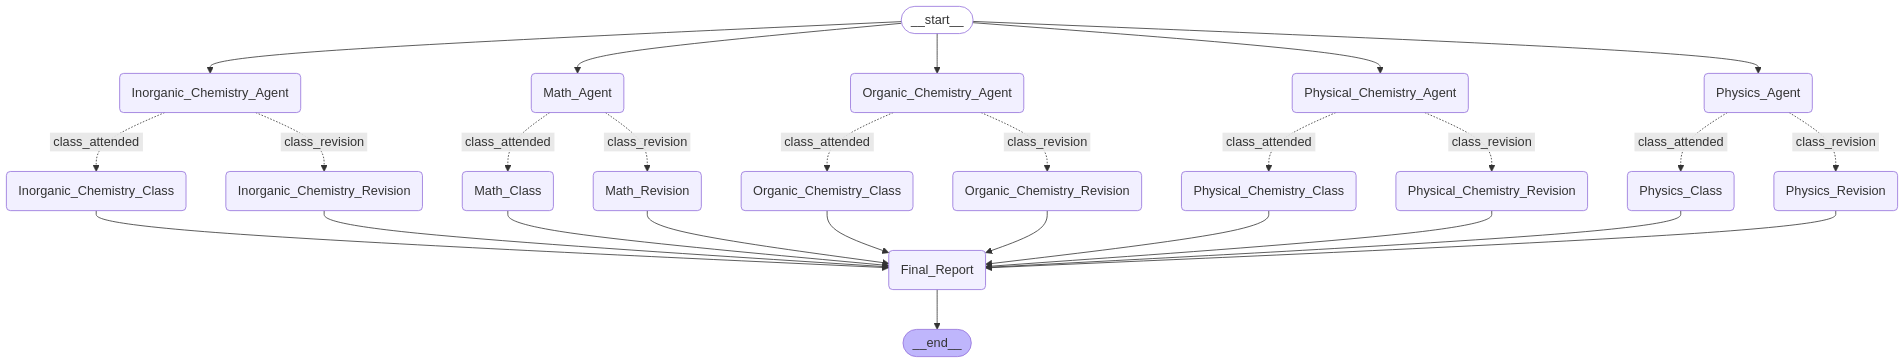

In [46]:
# Display the graph
from IPython.display import Image, display # type: ignore
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [47]:
## let us creating the structure of the input 
## we will be creating the input using different different methods
## in the first case the student has attended the class only
input = {"Math":{"math_class":{"topic_studied":"Matrices","understanding_rate":6,"confidence_level":5,"difficult_part":"matrix multiplication","pace":"medium","doubts_asked":0,"topic_new":"new","quiz_score":4}},
         "Physics":{"physics_class":{"topic_studied":"Electric Current","understanding_rate":7,"confidence_level":8,"difficult_part":"drift_current","pace":"medium","doubts_asked":0,"topic_new":"not new","quiz_score":6}},
         "Organic_Chemistry":{"organic_chemistry_class":{"topic_studied":"IUPAC Naming","understanding_rate":6,"confidence_level":8,"difficult_part":"memorizing","pace":"fast","doubts_asked":0,"topic_new":"new","quiz_zcore":3}},
          "Inorganic_Chemistry":{"inorganic_chemistry_class":{"topic_studied":"Periodic Table","understanding_rate":9,"confidence_level":8,"difficult_part":"memorizing","pace":"medium","doubts_asked":0,"topic_new":"new","quiz_zcore":2}},
          "Physical_Chemistry":{"physical_chemistry_class":{"topic_studied":"Acid and bases","understanding_rate":7,"confidence_level":8,"difficult_part":"reactions","pace":"slow","doubts_asked":0,"topic_new":"new","quiz_zcore":6}},
          }

In [61]:
inputs = {"input":input}
response = app.invoke(inputs)
response

{'input': {'Math': {'math_class': {'topic_studied': 'Matrices',
    'understanding_rate': 6,
    'confidence_level': 5,
    'difficult_part': 'matrix multiplication',
    'pace': 'medium',
    'doubts_asked': 0,
    'topic_new': 'new',
    'quiz_score': 4}},
  'Physics': {'physics_class': {'topic_studied': 'Electric Current',
    'understanding_rate': 7,
    'confidence_level': 8,
    'difficult_part': 'drift_current',
    'pace': 'medium',
    'doubts_asked': 0,
    'topic_new': 'not new',
    'quiz_score': 6}},
  'Organic_Chemistry': {'organic_chemistry_class': {'topic_studied': 'IUPAC Naming',
    'understanding_rate': 6,
    'confidence_level': 8,
    'difficult_part': 'memorizing',
    'pace': 'fast',
    'doubts_asked': 0,
    'topic_new': 'new',
    'quiz_zcore': 3}},
  'Inorganic_Chemistry': {'inorganic_chemistry_class': {'topic_studied': 'Periodic Table',
    'understanding_rate': 9,
    'confidence_level': 8,
    'difficult_part': 'memorizing',
    'pace': 'medium',
    'doub

In [49]:
type(response)

langgraph.pregel.io.AddableValuesDict

In [50]:
response

{'input': {'Math': {'math_class': {'topic_studied': 'Matrices',
    'understanding_rate': 6,
    'confidence_level': 5,
    'difficult_part': 'matrix multiplication',
    'pace': 'medium',
    'doubts_asked': 0,
    'topic_new': 'new',
    'quiz_score': 4}},
  'Physics': {'physics_class': {'topic_studied': 'Electric Current',
    'understanding_rate': 7,
    'confidence_level': 8,
    'difficult_part': 'drift_current',
    'pace': 'medium',
    'doubts_asked': 0,
    'topic_new': 'not new',
    'quiz_score': 6}},
  'Organic_Chemistry': {'organic_chemistry_class': {'topic_studied': 'IUPAC Naming',
    'understanding_rate': 6,
    'confidence_level': 8,
    'difficult_part': 'memorizing',
    'pace': 'fast',
    'doubts_asked': 0,
    'topic_new': 'new',
    'quiz_zcore': 3}},
  'Inorganic_Chemistry': {'inorganic_chemistry_class': {'topic_studied': 'Periodic Table',
    'understanding_rate': 9,
    'confidence_level': 8,
    'difficult_part': 'memorizing',
    'pace': 'medium',
    'doub

In [51]:
math_report = response.get("math_report_class")

In [52]:
math_report

"Today, you studied Matrices in Mathematics with an understanding rate of 6 out of 10. Your confidence level in solving questions related to this topic is at 5 out of 10. The class pace was medium and you found matrix multiplication to be quite confusing and challenging. Although the topic was new to you, you did not ask any doubts to the teacher during the session. \n\nIt's great that you attempted the quiz we provided and scored 4 out of 10. Remember, practice is key to improving in Mathematics. Focus on understanding the concepts behind matrix multiplication, as it forms the basis for many other topics in this area.\n\nMathematics may seem tough at times, but with consistent effort and practice, you can definitely improve. Don't be disheartened by a low quiz score - use it as motivation to work harder and ask questions when in doubt. Stay positive, keep practicing, and you will see progress. Believe in yourself and your abilities."

In [53]:
response.get("physics_report_class")

"Today's topic of Electric Current in Physics was studied with an understanding rate of 7 out of 10, which shows a good grasp of the concept. The student's confidence level in solving questions related to this topic is at 8, indicating a strong command over the subject matter. Despite finding the concept of drift current confusing and difficult, it is important to remember that practice and revisiting the topic will lead to better understanding.\n\nThe pace of the class was moderate, which allows for a balanced learning experience. Even though no doubts were asked in the class, it is encouraged to seek clarification whenever a concept seems unclear. Remember, it's okay to ask questions as it helps in reinforcing understanding.\n\nThe quiz provided by our system was attempted with a score of 6 out of 10. This result reflects the need for consistent practice and revision to improve performance. Focus on solving more problems to reinforce learning and enhance problem-solving skills.\n\nCo

In [54]:
response.get("organic_chemistry_report_class")

"Today, you studied the topic of IUPAC Naming in Organic Chemistry. Your understanding rate was 6 out of 10 and your confidence level in solving questions related to this topic was 8 out of 10. It is noted that you found the memorizing part of this topic confusing and difficult. The pace of the class was fast according to you, but you did not ask any doubts to the teacher.\n\nRemember, it is normal to find certain topics challenging, but with practice and perseverance, you can overcome these difficulties. To improve your understanding of IUPAC Naming, it is recommended to focus on practicing more questions and revising the concepts regularly.\n\nStay motivated and don't be disheartened by the challenges you face. Keep a positive attitude towards learning and believe in your ability to improve. Your dedication and hard work will surely pay off in the long run. Keep up the good work and continue to strive for progress each day."

In [55]:
response.get("inorganic_chemistry_report_class")

"Today, you delved into the topic of the Periodic Table in inorganic Chemistry with a strong understanding rate of 9 out of 10. Your confidence level in solving related questions stands at 8 out of 10. However, you found the memorization aspect to be quite confusing and difficult. Remember, practice makes perfect so keep revising to strengthen your understanding.\n\nThough the pace of the class was deemed medium by you, it's essential to stay focused and engaged during every session. Don't hesitate to ask questions if any doubts arise - this active participation will enhance your learning experience. \n\nSince the topic was new to you, it's normal to encounter challenges initially. Stay determined and persevere through difficulties. While your quiz score is not available, it's crucial to review your mistakes and work on improving your performance.\n\nMoving forward, make sure to allocate regular time for revision and practice. Utilize resources available to you, including additional st

In [56]:
response.get("physical_chemistry_report_class")

"Today, you studied the topic of Acids and Bases in Physical Chemistry. Your understanding rate was at 7 out of 10, which shows a good grasp of the concept. It's great to see your confidence level in solving questions related to this topic is at 8 out of 10. However, you found the reactions part a bit confusing and difficult, indicating an area where you can focus more in the future.\n\nAlthough the pace of the class was slow according to you, it's important to stay engaged and utilize this time to reinforce your understanding. Don't hesitate to ask questions in class if you come across any doubts - it's crucial for your learning process.\n\nSince this topic was new for you, it's understandable to face challenges. Remember, learning something new takes time and effort. Keep up the good work and stay motivated. Practice more problems to strengthen your understanding of the concepts.\n\nLastly, participation is key in your learning journey. Try to engage more in class discussions and act

In [62]:
final_report = response.get("final_report")

In [63]:
response.get("final_score")

3

In [59]:
final_report

"Today, you made progress in Mathematics, Physics, Organic Chemistry, Inorganic Chemistry, and Physical Chemistry. Despite facing challenges in matrix multiplication and drift current, you displayed a good understanding of the concepts overall. Remember, practice is key to improvement, so focus on strengthening your foundation in these topics. Your confidence levels are promising, indicating a strong command over the subjects. It's essential to actively participate in class, ask questions when in doubt, and engage in regular practice and revision. Keep a positive attitude towards learning, believe in your abilities, and stay motivated to overcome any obstacles. Your dedication and hard work will surely pay off in the long run. Just keep practicing and pushing yourself to do better every day."

In [64]:
final_report

"Today, you made good progress in your IIT-JEE preparation. In Mathematics, although you found matrix multiplication confusing, it's normal when learning a new topic like Matrices. Remember to ask doubts and practice more problems to build your confidence. In Physics, your understanding of Electric Current was commendable, but ensure you clarify doubts on drift current. Stay focused in class and practice consistently. Your study of IUPAC Naming in Organic Chemistry showed improvement, keep practicing regularly to reinforce learning. In Inorganic Chemistry, your grasp on the Periodic Table was strong, work on memorization techniques to deepen understanding. In Physical Chemistry, despite finding reactions challenging, with more practice and asking doubts, you will improve. Stay motivated, keep pushing yourself, and believe in your ability to overcome challenges in your IIT-JEE preparation."